In [1]:
%pip install scipy matplotlib
%pip install git+https://github.com/kerim371/wiggle.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/kerim371/wiggle.git to /tmp/pip-req-build-86t_2pob
  Running command git clone --filter=blob:none --quiet https://github.com/kerim371/wiggle.git /tmp/pip-req-build-86t_2pob
  Resolved https://github.com/kerim371/wiggle.git to commit 5846c09adbcfa9016896a3c047f4f61a10e630d0
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
raw_cdp = 's_cdp.rsf'
sample = 'sample.rsf'
header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'
offsets = 'offsets.rsf'
cdp_offsets = 'cdp_offsets.rsf'
cdp_mask = "cdp_mask.rsf"
wavelet_file = "FarField.dat"

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from rsf.proj import *
import rsf.api as sf
import m8r
from m8r import view
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from wiggle.wiggle import wiggle
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

env: DATAPATH=/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/


Retrieve sample Shot Point and CDP

In [3]:
# Grab only shotpoint 1
!sfwindow < {raw} n2=120 > {sample}
!sfin {sample}

sample_cdp = 'sample_cdp.rsf'
sample_cdp_offsets = 'sample_cdp_offsets.rsf'

cdp = 1000
!sfwindow f3={cdp} n3=1 < {raw_cdp} > {sample_cdp}
!sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
    sfwindow f3={cdp} n3=1 | \
    sfheadermath output='offset'/1000. > {sample_cdp_offsets}
!sfin {sample_cdp}
!sfin {sample_cdp_offsets}

sample.rsf:
    in="/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/sample.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          label1="Time" unit1="s" 
    n2=120         d2=1           o2=0          label2="Trace" 
	180000 elements 720000 bytes
sfintbin: 2142 of 2142;
sample_cdp.rsf:
    in="/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/sample_cdp.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          label1="Time" unit1="s" 
    n2=60          d2=1           o2=0          label2="Trace" 
    n3=1           d3=1           o3=1001       
	90000 elements 360000 bytes
sample_cdp_offsets.rsf:
    in="/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/sample_cdp_offsets.rsf@"
    esize=4 type=float form=native 
    n1=1           d1=1           o1=0          
    n2=60          d2=1           o2=0          
    n3=1           d3=1           o3=1001       
	60 elements 240 bytes


Inspect Far Wavefield

In [4]:
wavelet = np.loadtxt(wavelet_file)
dt = 0.001
fs = 1./dt
t = np.arange(wavelet.shape[0]) * dt

# Get the first "non zero" time
t0 = np.argmax(np.abs(wavelet) > 0.03) * dt

xf, Pxx = welch(wavelet, fs, detrend=None, nfft=256, nperseg=128)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Wavelet', 'Amp spec'))
fig.add_trace(go.Scatter(x=t, y=wavelet, name="wavelet", fill='tonextx'), row=1, col=1)
fig.add_trace(go.Scatter(x=xf, y=10*np.log10(Pxx), name="wavelet amp spec", fill='tozerox'), row=1, col=2)
fig.add_vline(x=t0, row=1, col=1)
fig.add_vline(x=125, row=1, col=2)
fig.add_annotation(x=t0, y=20, text=f"Time delay: {t0*1000}ms", xshift=0,
  showarrow=True, align='center', arrowhead=1, xanchor='auto', textangle=0, ax=100, ay=-30, row=1, col=1)
fig.add_annotation(x=125, y=-30, text=f"Rec ghost notch: 125Hz", xshift=0,
  showarrow=True, align='center', arrowhead=1, xanchor='auto', textangle=0, ax=80, ay=-20, row=1, col=2)
fig.update_xaxes(title="Time [ms]", row=1, col=1)
fig.update_yaxes(title="Amplitude", row=1, col=1)
fig.update_xaxes(title="Frequency [Hz]", row=1, col=2)
fig.update_yaxes(title="Power Spectral Density [Db]", row=1, col=2)
fig.show()

Write the original wavelet to RSF format

In [5]:
wavelet_original = 'original_source_signature.rsf'

out = sf.Output(wavelet_original)
out.put('n1', wavelet.shape[0])
out.put('d1', dt)
out.put('o1', 0)
out.write(wavelet.astype(np.float32))
out.close()

## Receiver ghost component

Since the cable towing depth is 10 m and the water velocity is 1500 m/s, the delay time for the receiver ghosting is:

In [6]:
v_water = 1.5 #km/s
cable_towing_depth = 0.01 # km 

tr = (2*cable_towing_depth)/v_water # Receiver ghosting delay (s)

print('Delay time for receiver ghost: %f s' % tr)

Delay time for receiver ghost: 0.013333 s


Generate spickes for modeling receiver ghosts

In [7]:
pad_len = 1024
wavelet_pad = np.pad(wavelet, (0, pad_len - len(wavelet)), 'constant')
t = np.arange(wavelet_pad.size) * dt

receiver_ghost_filter = np.zeros(wavelet_pad.size)
receiver_ghost_filter[0] = 1
receiver_ghost_filter[int(tr/dt)] = -1

fig = px.line(x=t, y=receiver_ghost_filter, title='Spikes to model the receiver ghost')
fig.update_xaxes(title="Time [ms]", row=1, col=1, range=[0, 0.1])
fig.show()

Visualize all necessary information

In [8]:
receiver_ghost = np.convolve(wavelet, receiver_ghost_filter, mode='full')

t = np.arange(receiver_ghost.size)*dt

xf, Pxx = welch(receiver_ghost, fs, detrend=None, nfft=256, nperseg=128)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Wavelet deghost', 'Amp spec'))
fig.add_trace(go.Scatter(x=t, y=receiver_ghost, name="wavelet deghost", fill='tonextx'), row=1, col=1)
fig.add_trace(go.Scatter(x=xf, y=10*np.log10(Pxx), name="wavelet amp spec", fill='tozerox'), row=1, col=2)
fig.add_vline(x=t0, row=1, col=1)
fig.add_vline(x=125, row=1, col=2)
fig.add_vline(x=1/tr, row=1, col=2)
fig.add_annotation(x=t0, y=20, text=f"Time delay: {t0*1000}ms", xshift=0,
  showarrow=True, align='center', arrowhead=1, xanchor='auto', textangle=0, ax=100, ay=-30, row=1, col=1)
fig.add_annotation(x=125, y=-30, text=f"Src ghost notch: 125Hz", xshift=0,
  showarrow=True, align='center', arrowhead=1, xanchor='auto', textangle=0, ax=80, ay=-20, row=1, col=2)
fig.add_annotation(x=1/tr, y=-20, text=f"Rec ghost notch: {1/tr}Hz", xshift=0,
  showarrow=True, align='center', arrowhead=1, xanchor='auto', textangle=0, ax=110, ay=-30, row=1, col=2)
fig.update_xaxes(title="Time [ms]", row=1, col=1, range=[0, 0.5])
fig.update_yaxes(title="Amplitude", row=1, col=1)
fig.update_xaxes(title="Frequency [Hz]", row=1, col=2)
fig.update_yaxes(title="Power Spectral Density [Db]", row=1, col=2)
fig.show()

Write the wavelet to disk, I'm doing the wavelet filtering, resampling and the data deghosting using Madagascar programs.

In [9]:
wavelet_receiver_ghosting = 'receiver_ghosting_source_signature.rsf'

out = sf.Output(wavelet_receiver_ghosting)
out.put('n1', receiver_ghost.shape[0])
out.put('d1', dt)
out.put('o1', 0)
out.put('n2', 1)
out.put('d2', 0)
out.put('o2', 0)
out.write(receiver_ghost.astype(np.float32))
out.close()

## Filtering the receiver ghosting

As seen on the spectra above, there are several notches on the spectra for this wavelet. I'll use a low pass filter with cut frequency of 125 Hz and a gentle slope, that way we may remove noise that will polute the deconvolution further ahead. Also, I'll resample this wavelet to 4 ms

To make signtature deconvolution we also need a shorter and smoother version of the wavelet, otherwise the signal gets very polluted with noise.

In [10]:
wavelet_receiver_ghosting_resampled = 'receiver_ghosting_source_signature_resampled.rsf'
f1 = int(t0/dt) # Remove the time delay before resampling

!sfwindow f1={f1} < {wavelet_receiver_ghosting} | sfput o1=0 |\
  sfbandpass fhi=65 nphi=8 |\
  sfwindow j1=4 | sfwindow n1=128 |\
  sfpad n1=1500 > {wavelet_receiver_ghosting_resampled}
!sfin {wavelet_receiver_ghosting_resampled}

# Create a smooth and shorter wavelet. I'll also go ahead and pad it to the correct lengh

wavelet_receiver_ghosting_smooth = 'receiver_smooth_wavelet.rsf'

!sfsmooth rect1=3 repeat=3 < {wavelet_receiver_ghosting} |\
  sfcut f1=99 | sfbandpass fhi=65 nphi=8 | sfwindow f1={f1} |\
  sfput o1=0 | sfwindow j1=4 | sfwindow n1=128  | sfpad n1=1500 > {wavelet_receiver_ghosting_smooth}

w_deg = np.array(sf.Input(wavelet_receiver_ghosting_resampled))
w_deg_sm = np.array(sf.Input(wavelet_receiver_ghosting_smooth))

# write deghosted wavelet
deghosted_wavelet_file = 'FarField_deghosted.dat'
np.savetxt(deghosted_wavelet_file, w_deg_sm)

fig = px.line()
fig.add_trace(go.Scatter(x=t, y=w_deg, name="wavelet deghost"))
fig.add_trace(go.Scatter(x=t, y=w_deg_sm, name="wavelet deghost smooth"))
fig.update_xaxes(title="Time [ms]", row=1, col=1, range=[0, 0.2])
fig.show()

receiver_ghosting_source_signature_resampled.rsf:
    in="/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/receiver_ghosting_source_signature_resampled.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          
    n2=1           d2=0           o2=0          
	1500 elements 6000 bytes


## Applying the de-ghosting filter to a sample shot

This can be done using a matched filter, which can be implemented by simple cross-correlation with our minimum phase equivalent resampled wavelet.

The processing steps are:

- Pad the shot and wavelet to the same power of two (2048 samples in this case)
- Use FFT to put both wavelet and shot in frequency domain
- Calculate a apropriate signature deconvolution filter for each source wavelet.
- Multiply in frequency domain
- Do inverse Fourier transform by FFT to put the data back into time domain
- Check for spurious noises and high frequency contamination. If present, check the filtering parameters for each wavelet.
- Profit (?)

In [11]:
shot_fourier = 'sample_fourier.rsf'

# First let's pad and FFT the shot
!sffft1 < {sample} > {shot_fourier}
!sfin {shot_fourier}

sffft1: using 8 of 8 threads
sample_fourier.rsf:
    in="/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/sample_fourier.rsf@"
    esize=8 type=complex form=native 
    n1=751         d1=0.166667    o1=0          label1="Frequency" unit1="Hz" 
    n2=120         d2=1           o2=0          label2="Trace" 
	90120 elements 720960 bytes


Build and apply the first deconvolution operator, perform inverse fourier transform, remove padding and save the shot.

sffft1: using 8 of 8 threads
sffft1: using 8 of 8 threads
sffft1: using 8 of 8 threads


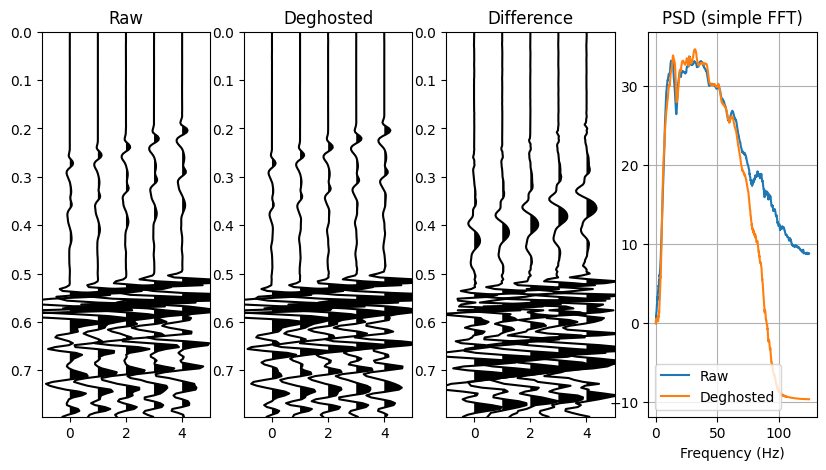

In [12]:
# Load shot and visualize it
sample_in = sf.Input(sample)
d1 = sample_in.float('d1')
n2 = sample_in.int('n2')

# FFT the shot and smooth version of the wavelet
!sffft1 < {wavelet_receiver_ghosting_smooth} > d.rsf

# Create a FFT source wavelet
!sffft1 < {wavelet_receiver_ghosting_resampled} > p.rsf

# Create a decon operator
decon_operator = 'receiver_deghost_operator.rsf'

!sfmath p=p.rsf d=d.rsf output='(d*conj(p))/(p*conj(p) + 1e-6)' | sfput d2=1 > {decon_operator}

sample_rec_deghost = 'sample_deghost.rsf'

# Filter a single shot
!sfspray < {decon_operator} n={n2} | sfmul {shot_fourier} |\
    sffft1 inv=y | sfbandpass flo=6 fhi=75 nphi=8 > {sample_rec_deghost}

# Load shot and visualize it
sample_arr = np.array(sample_in)

sample_rec_deghost_arr = np.array(sf.Input(sample_rec_deghost))
t = np.arange(sample_arr.shape[1]) * d1

i0 = 0
i1 = 200
j0 = 115
j1 = 120
gain = 0.5
titles = ["Raw", "Deghosted", "Difference"]

fig, axs = plt.subplots(1,4)
wiggle(sample_arr.transpose()[i0:i1,j0:j1], tt=t[i0:i1], sf=gain, ax=axs[0])
wiggle(sample_rec_deghost_arr.transpose()[i0:i1,j0:j1], tt=t[i0:i1], sf=gain, ax=axs[1])
wiggle((sample_arr-sample_rec_deghost_arr).transpose()[i0:i1,j0:j1], tt=t[i0:i1], sf=gain, ax=axs[2])
axs[0].set_title(titles[0])
axs[1].set_title(titles[1])
axs[2].set_title(titles[2])

# spectrums
for i, data in enumerate([sample_arr, sample_rec_deghost_arr]):
  pad_len = 2048

  shot_pad = np.pad(data,  ((0,0), (0, pad_len - sample_arr.shape[1])), 'constant')

  Pxx = np.abs(np.fft.fft(shot_pad, axis=1))
  Pxx = np.mean(Pxx, axis=0)
  freqs = np.fft.fftfreq(shot_pad.shape[1], 0.004)

  Pxx = Pxx[freqs >= 0]
  freqs = freqs[freqs >= 0]

  axs[3].plot(freqs, 10*np.log10(Pxx/Pxx[0]), label=titles[i])

plt.grid()

plt.xlabel('Frequency (Hz)')
plt.title('PSD (simple FFT)')

plt.legend(loc='best');
fig.set_size_inches(10, 5)

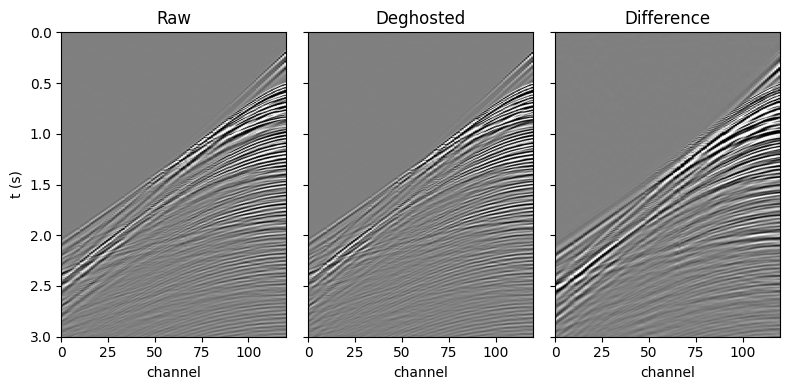

In [13]:
plt.figure(figsize=(8, 4))
t = np.arange(sample_arr.shape[1]) * d1
for i, data in enumerate([sample_arr, sample_rec_deghost_arr, sample_arr-sample_rec_deghost_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(3,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Now apply the processing to the whole dataset

In [14]:
raw_deghost = "s_deghost.rsf"
raw_deghost_cdp = "s_deghost_cdp.rsf"

raw_fourier = "s_fourier.rsf"
proc = raw_deghost
proc_cdp = raw_deghost_cdp

raw_in = sf.Input(raw)
n2 = raw_in.int('n2')

# First let's pad and FFT the shot
!sffft1 < {raw} > {raw_fourier}

# Filter whole data
!sfspray n={n2} < {decon_operator} | sfmul {raw_fourier} |\
    sffft1 inv=y | sfbandpass flo=6 fhi=75 nphi=8 > {proc}
!sfintbin < {proc} yk=cdp xk=cdpt head={header_complete_int} > {proc_cdp}

sffft1: using 8 of 8 threads
sffft1: using 8 of 8 threads
sfintbin: 2142 of 2142;


## Zero Offset stack

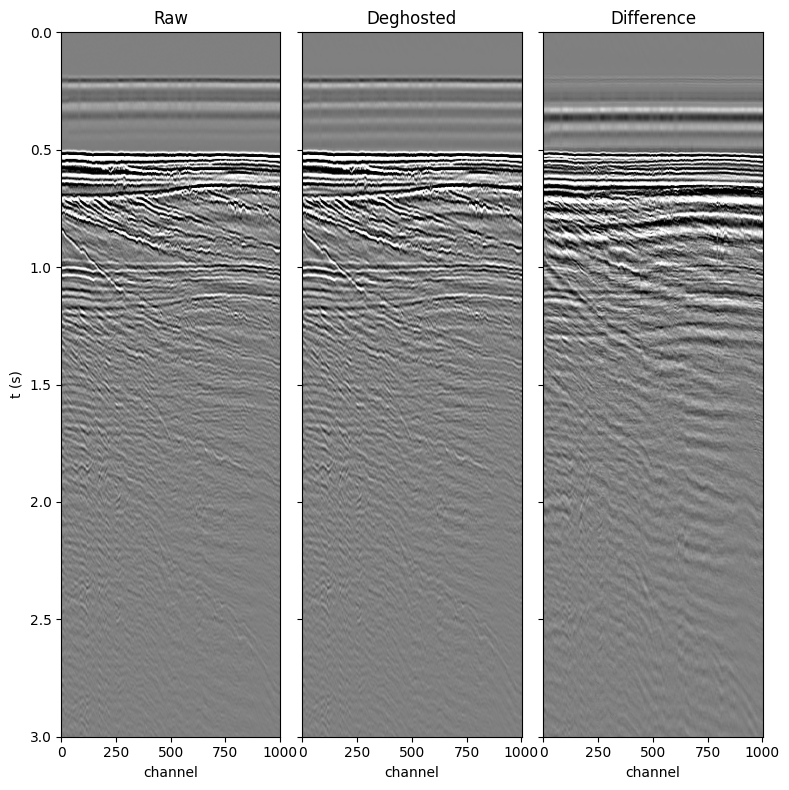

In [15]:
raw_stack = 's_cdp_vconst_1chan_stk.rsf'
proc_stack = 's_deghost_cdp_vconst_1chan_stk.rsf'
offset_mask = 'offset_mask.rsf'

!sfheadermath < {header_complete} output='offset' | sfmask min=-262 > {offset_mask}
!sfheaderwindow < {raw} mask={offset_mask} > {raw_stack}
!sfheaderwindow < {raw_deghost} mask={offset_mask} > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8,8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(3,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

## Brute stack
1. Constant velocity stacks:

sfstacks: CMP 1935 of 2142;sfpow: build/api/c/file.c: trouble reading: 368 of 2048
sfstacks: build/api/c/file.c: trouble reading: 89632 of 90000
sftransp: build/api/c/file.c: trouble reading: 11604000 of 12852000
sfput: build/api/c/file.c: trouble reading: 0 of 4096
sfstacks: CMP 2142 of 2142;


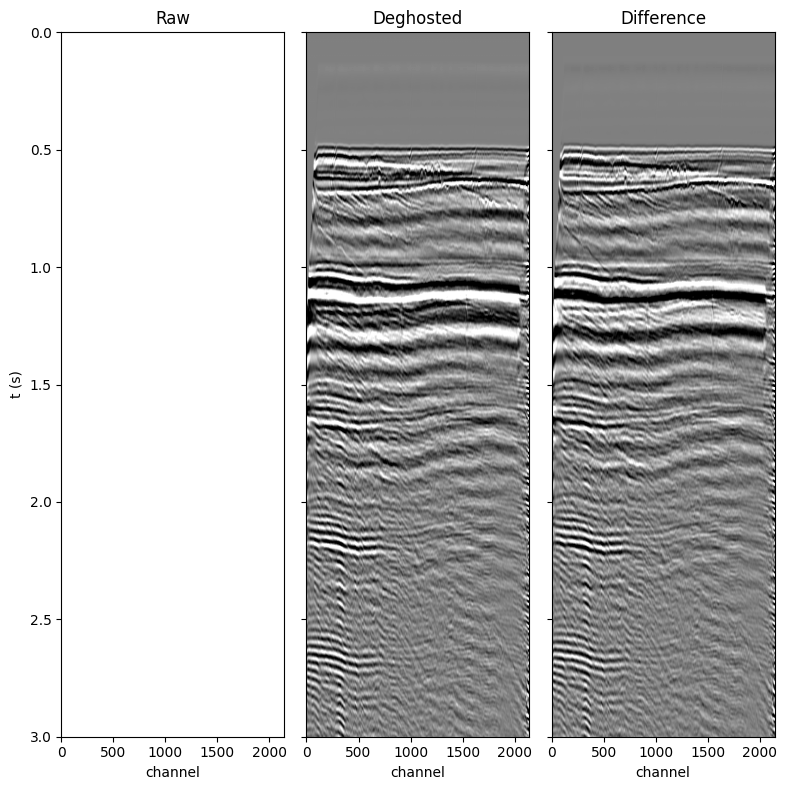

In [16]:
raw_stack = 's_cdp_vconst_stk.rsf'
proc_stack = 's_deghost_cdp_vconst_stk.rsf'

!sfpow pow1=2 < {raw_cdp} | \
    sfstacks half=n offset={cdp_offsets} nv=1 v0=1.5 dv=1 | \
    sftransp plane=23 | \
    sfput label2=cdp > {raw_stack}
!sfpow pow1=2 < {raw_deghost_cdp} | \
    sfstacks half=n offset={cdp_offsets} nv=1 v0=1.5 dv=1 | \
    sftransp plane=23 | \
    sfput label2=cdp > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8,8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(3,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

2. Generated velocity model stacks:

Generate initial velocity model

In [17]:
vnmo_rsf = 'vnmo.rsf'

raw_cdp_in = sf.Input(raw_cdp)
nsamp = raw_cdp_in.int('n1')
ncdp = raw_cdp_in.int('n3')

import numpy.matlib
vnmo = np.linspace(1.2, 4.0, num=nsamp)
vnmo = np.matlib.repmat(vnmo, ncdp, 1)

out = sf.Output(vnmo_rsf)
out.put('o1', raw_cdp_in.float('o1'))
out.put('o2', raw_cdp_in.float('o3'))
out.put('n1', raw_cdp_in.int('n1'))
out.put('n2', raw_cdp_in.int('n3'))
out.put('d1', raw_cdp_in.float('d1'))
out.put('d2', raw_cdp_in.float('d3'))

out.write(vnmo.astype(np.float32))
out.close()

In [18]:
# View generated velocity model if needed
# !sfgrey < {vnmo_rsf} color=j | sfpen

Create water velocity model

In [19]:
vnmow_rsf = 'vnmow.rsf'

raw_cdp_in = sf.Input(raw_cdp)
nsamp = raw_cdp_in.int('n1')
ncdp = raw_cdp_in.int('n3')

vnmow = np.ones((ncdp,nsamp))*v_water

out = sf.Output(vnmow_rsf)
out.put('o1', raw_cdp_in.float('o1'))
out.put('o2', raw_cdp_in.float('o3'))
out.put('n1', raw_cdp_in.int('n1'))
out.put('n2', raw_cdp_in.int('n3'))
out.put('d1', raw_cdp_in.float('d1'))
out.put('d2', raw_cdp_in.float('d3'))

out.write(vnmow.astype(np.float32))
out.close()

In [20]:
# View generated velocity model if needed
# !sfgrey < {vnmow_rsf} color=j | sfpen

Compare stacks

sfnmo: CMP 1935 of 2142;sfpow: build/api/c/file.c: trouble reading: 368 of 2048
sfnmo: build/api/c/file.c: trouble reading: 1132 of 1500
sfstack: build/api/c/file.c: trouble reading: 0 of 1500
sfagc: build/api/c/file.c: trouble reading: 0 of 1500
sfnmo: CMP 2142 of 2142;


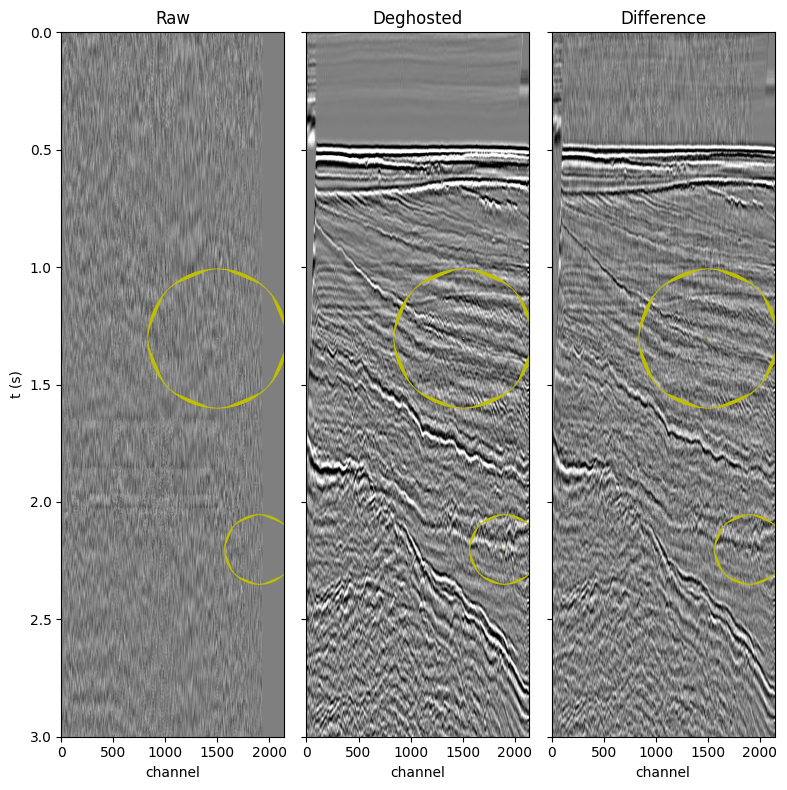

In [21]:
raw_stack = 's_cdp_stk.rsf'
proc_stack = 's_deghost_cdp_stk.rsf'

!sfpow tpow=2 < {raw_cdp} | \
    sfnmo velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack | sfagc > {raw_stack}

!sfpow tpow=2 < {proc_cdp} | \
    sfnmo velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack | sfagc > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8,8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    plt.scatter(x=1500, y=1.3, s=1, alpha=1, c='y', linewidths=100)
    plt.scatter(x=1900, y=2.2, s=1, alpha=1, c='y', linewidths=50)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(3,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

In [22]:
# in_h = sf.Input(raw_tfile)
# print('n1:', in_h.int('n1'))
# print('n2:', in_h.int('n2'))

# data_h = np.zeros((in_h.int('n2'), in_h.int('n1')), dtype=np.float32)
# in_h.read(data_h)

# # Iterate over file w/ SEG-Y keyword/index relation
# keys = {}

# for index, row in pd.read_csv('keys.txt', sep=' ').iterrows():
#   keys[row.key] = row.id

# df_h = pd.DataFrame()

# for k in keys:
#   df_h[k] = data_h[:,keys[k]]

# df_h[['offset', 'ep', 'cdp', 'sx', 'gx']].head()

In [23]:
# ucdp = np.sort(df_h.cdp.unique())
# ncdp = ucdp.size
# t = np.arange(raw_in.shape()[1]) * d1

# from scripts.interp_vels import interp_vels_cpseis

# cpseis_vel_file = "/mnt/HDD_2TB/cpseis_data/projects/VikingGraben/line12/data/vel_picks.vel"
# points, vals = interp_vels_cpseis(cpseis_vel_file)
# # madagascar works with seconds and km/s
# vals = vals/1000.0

# # add corner values for extrapolation instead of  NaN
# ind = np.where(points[:,0] == points[:,0].min())[0]
# i = np.argmin(points[ind,1])
# vals = np.append(vals, [vals[ind[i]]])
# points = np.append(points, [[ucdp[0], t[0]]], axis=0)
# i = np.argmax(points[ind,1])
# vals = np.append(vals, [vals[ind[i]]])
# points = np.append(points, [[ucdp[0], t[-1]]], axis=0)

# ind = np.where(points[:,0] == points[:,0].max())[0]
# i = np.argmin(points[ind,1])
# vals = np.append(vals, [vals[ind[i]]])
# points = np.append(points, [[ucdp[-1], t[0]]], axis=0)
# i = np.argmax(points[ind,1])
# vals = np.append(vals, [vals[ind[i]]])
# points = np.append(points, [[ucdp[-1], t[-1]]], axis=0)

# # interpolation
# grid_cdp, grid_t = np.meshgrid(ucdp, t, indexing='ij')
# vnmo = griddata(points, vals, (grid_cdp, grid_t), method='linear')

# fig = plt.figure()
# im = plt.imshow(vnmo.transpose(), cmap=plt.cm.rainbow, interpolation=None)
# plt.colorbar(im)

# vnmo_rsf = 'vnmo.rsf'

# o1 = raw_in.float('o1')
# o2 = raw_in.float('o2')
# d1 = raw_in.float('d1')
# d2 = raw_in.float('d2')
# n1 = raw_in.int('n1')
# n2 = raw_in.int('n2')

# out = sf.Output(vnmo_rsf)
# out.put('n1', n1)
# out.put('n2', ncdp)
# out.put('d1', d1)
# out.put('d2', d2)
# out.put('o1', o1)
# out.put('o2', o2)

# out.write(vnmo.astype(np.float32))
# out.close()

Sorting by CDP

In [24]:
# raw_cdp = 's_cdp.rsf'
# proc_cdp = 's_deghost_cdp.rsf'

# !sfintbin < {raw} yk=cdp xk=cdpt head={header_complete_int} > {raw_cdp}
# !sfin < {raw_cdp}

# !sfintbin < {raw_proc} yk=cdp xk=cdpt head={header_complete_int} > {proc_cdp}
# !sfin < {proc_cdp}

# !sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
#     sfheadermath output='offset'/1000. > {cdp_offsets}

In [25]:
# raw_stack = 's_cdp_stk.rsf'
# proc_stack = 's_deghost_cdp_stk.rsf'

# !sfpow tpow=2 < {raw_cdp} | \
#     sfnmo velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
#     sfstack | sfagc > {raw_stack}

# !sfpow tpow=2 < {proc_cdp} | \
#     sfnmo velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
#     sfstack | sfagc > {proc_stack}

In [26]:
# # Load stacks and visualize it
# raw_stack_in = sf.Input(raw_stack)
# proc_stack_in = sf.Input(proc_stack)

# raw_stack_arr = np.array(raw_stack_in)
# proc_stack__arr = np.array(proc_stack_in)

# for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
#     plt.subplot(1,3, i+1)
#     perc = np.percentile(data.ravel(), 99)
#     extent = [0, data.shape[0], t[-1], t[0]]

#     plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
#               cmap='gray_r')
#     plt.scatter(x=1900, y=2.2, s=1, alpha=1, c='y', linewidths=50)

#     if i == 0:
#         plt.ylabel('t (s)')
#     plt.xlabel('channel')

#     plt.title(titles[i])
#     plt.ylim(3,0)

# for ax in plt.gcf().axes:
#     try:
#         ax.label_outer()
#     except:
#         pass
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.1)